### Importing Libraies

In [218]:
import random
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from numpy import interp
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [219]:

import os
import joblib
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [220]:
OUTPUT_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Data Load

##### LSGT

In [221]:
input_data_dir = "Data"
disease_name = pd.read_csv(os.path.join(input_data_dir, 'disease_name.csv'),header=None)
snoRNA_name = pd.read_csv(os.path.join(input_data_dir, 'snoRNA_name.csv'),header=None)

###### Big DataSet


In [222]:
SnoRNA_similarity = pd.read_csv(os.path.join(input_data_dir, 'snoRNA_similarity.csv'))
known_association = pd.read_csv(os.path.join(input_data_dir, 'known_snoRNA_disease.csv'), header=None)
disease_similarity = pd.read_csv(os.path.join(input_data_dir, 'disease_similarity.csv'), header=None)


###### K

In [223]:
# SnoRNA_similarity = pd.read_csv(os.path.join(input_data_dir, 'IRS_matrix.csv'), header=None)
# known_association = pd.read_csv(os.path.join(input_data_dir, 'known_snoRNA_disease.csv'), header=None)
# disease_similarity = pd.read_csv(os.path.join(input_data_dir, 'IDS_matrix.csv'), header=None)


###### I

In [224]:
# SnoRNA_similarity = pd.read_csv(os.path.join(input_data_dir, 'KS_matrix.csv'), header=None)
# known_association = pd.read_csv(os.path.join(input_data_dir, 'known_snoRNA_disease.csv'), header=None)
# disease_similarity = pd.read_csv(os.path.join(input_data_dir, 'IDS_matrix.csv'), header=None)

##### PSnoD

In [225]:
# input_data_dir = "PSnoD"
# disease = pd.read_csv(os.path.join(input_data_dir, 'disease_sim_graph_filtered.csv'))
# snoRNA = pd.read_csv(os.path.join(input_data_dir, 'snoRNA_4mer_similarity.csv'))
# relation = pd.read_csv(os.path.join(input_data_dir, 'relationship_matrix_filtered.csv'))

# len(disease), len(snoRNA), len(relation)

In [226]:
# disease_name = disease.iloc[:,0:1]
# snoRNA_name = snoRNA.iloc[:,0:1]
# SnoRNA_similarity = snoRNA.iloc[:,1:]
# known_association = relation.iloc[:, 1:].T
# disease_similarity = disease.iloc[:,1:]
# disease_name.shape , snoRNA_name.shape , SnoRNA_similarity.shape , known_association.shape , disease_similarity.shape

##### Shape

In [227]:
# disease_name.shape , snoRNA_name.shape , SnoRNA_similarity.shape , known_association.shape , disease_similarity.shape

#### Data preprocessing

##### List to Numpy

In [228]:
disease_semantic_similarity = np.zeros(disease_similarity.shape) 
snoRNA_functional_similarity = np.zeros(SnoRNA_similarity.shape) 
adjacency_matrix = np.zeros(known_association.shape) 

disease_semantic_similarity = disease_similarity.values
snoRNA_functional_similarity = SnoRNA_similarity.values
adjacency_matrix = known_association.values

In [229]:
adjacency_matrix.shape , disease_semantic_similarity.shape , snoRNA_functional_similarity.shape

((335, 112), (112, 112), (335, 335))

##### Separation and permutation

In [230]:
unknown = []
known = []
for x in range(known_association.shape[0]):
    for y in range(known_association.shape[1]):
        if adjacency_matrix[x, y] == 0:
            unknown.append((x, y))
        else:
            known.append((x, y))



In [231]:
len(unknown), len(known) 

(36510, 1010)

In [232]:
         
major = []
for z in range(len(unknown)):
    a = disease_semantic_similarity[unknown[z][1], :].tolist()
    b = snoRNA_functional_similarity[unknown[z][0], :].tolist()
    q = a + b
    major.append(q) 

In [233]:
len(unknown), len(known), len(major)

(36510, 1010, 36510)

##### Clustaring

In [234]:
n_clusters = 23
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(major)
labels = kmeans.labels_

disease_rna_tup = defaultdict(list)
for (rna, dis), label in zip(unknown, labels):
    disease_rna_tup[label].append((rna, dis))



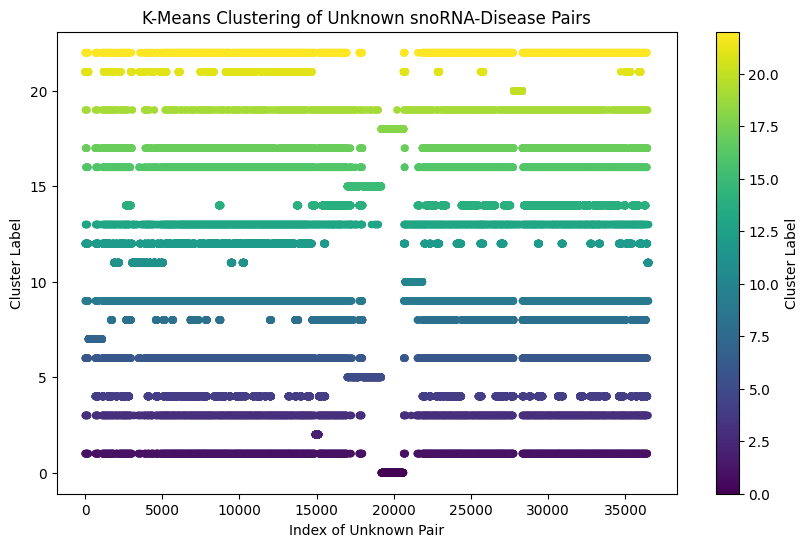

In [235]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis', s=20)
plt.title('K-Means Clustering of Unknown snoRNA-Disease Pairs')
plt.xlabel('Index of Unknown Pair')
plt.ylabel('Cluster Label')
plt.colorbar(label='Cluster Label')
plt.show()

#### Final datasets are being prepared

In [236]:
sampled_disease_rna_tup = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
n = 0
for i in range(len(disease_rna_tup)):
    sampled_disease_rna_tup[i] = random.sample(disease_rna_tup[i], int((len(disease_rna_tup[i])/len(labels)) * len(known)))

dataset = []
for rna in range(known_association.shape[0]):
    for disease in range(known_association.shape[1]):
        for i in range(len(sampled_disease_rna_tup)):
            if (rna, disease) in sampled_disease_rna_tup[i]:
                dataset.append((rna, disease))


for rna in range(known_association.shape[0]):
    for disease in range(known_association.shape[1]):
        if (rna, disease) in known:
            dataset.append((rna, disease))

length = len(dataset)
print(length)


2007


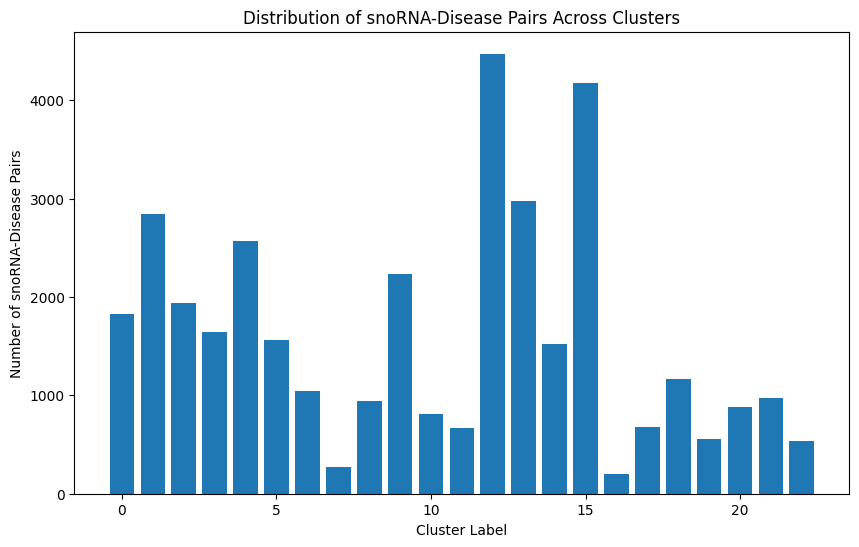

In [237]:
plt.figure(figsize=(10, 6))
plt.bar(range(n_clusters), [len(cluster) for cluster in disease_rna_tup.values()])
plt.xlabel('Cluster Label')
plt.ylabel('Number of snoRNA-Disease Pairs')
plt.title('Distribution of snoRNA-Disease Pairs Across Clusters')
plt.show()

In [238]:
selected_x = []
selected_y = []
#now I am just taking only the similarities of disease and rna of sampled data.
for data in dataset:
    a = disease_semantic_similarity[data[1], :].tolist()
    b = snoRNA_functional_similarity[data[0], :].tolist()
    q = a + b
    selected_x.append(q)

    if (data[0], data[1]) in known:
        selected_y.append(1)
    else:
        selected_y.append(0)

selected_data_np = np.array(selected_x)
selected_label_np = np.array(selected_y)



#### Model

##### Classifier Parameter

In [239]:
classifiers = {
    "SVM": (
        SVC(kernel='rbf', probability=True),
        {'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [1, 0.1, 0.01, 0.001]}
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {'clf__n_estimators': [50, 100], 'clf__max_depth': [None, 5, 10]}
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=1000),
        {'clf__C': [0.01, 0.1, 1, 10]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {'clf__n_neighbors': [3, 5, 7], 'clf__weights': ['uniform', 'distance']}
    )

}

##### Model Arcitecture

###### Others


In [240]:
# Try imports for XGBoost, LightGBM, Keras (TensorFlow)
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGB = True
except Exception as e:
    HAS_LGB = False

try:
    import tensorflow as tf
    from tensorflow import keras
    HAS_TF = True
except Exception as e:
    HAS_TF = False

In [241]:
# from lightgbm import early_stopping, log_evaluation
# from sklearn import pipeline


# def evaluate_cv(model_name, model_builder, X, y, scale_for_nn=False, epochs=30, batch_size=32):

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     mean_fpr = np.linspace(0, 1, 100)
#     mean_recall = np.linspace(0, 1, 100)
#     tprs = []
#     aucs = []
#     precisions = []
#     scores = []
#     roc_auc_scores = []
#     y_true_all = []
#     y_pred_all = []

#     fold_idx = 0
#     param_grid = {'SVM__C': [0.1, 1, 10, 100], 'SVM__gamma': [1, 0.1, 0.01, 0.001]}

#     # Use GridSearchCV to find the optimal parameters
#     grid = GridSearchCV(pipeline, param_grid, cv=5)

#     for train_idx, test_idx in skf.split(X, y):
#         fold_idx += 1
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]

#         # scale only for NN models or if specified
#         if model_name == 'DNN' or scale_for_nn:
#             scaler = StandardScaler(with_mean=False)
#             X_train = scaler.fit_transform(X_train)
#             X_test = scaler.transform(X_test)
 

#         # If model_builder returns an sklearn estimator:
#         if hasattr(model_builder, '__call__') and model_name != 'DNN' and model_name not in ('xgboost', 'lightgbm_custom'):
            
#             model = model_builder()
#             model.fit(X_train, y_train)
#             proba = model.predict_proba(X_test)[:, 1]
#             pred = model.predict(X_test)
#             # joblib.dump(model, os.path.join(OUTPUT_DIR, f"{model_name}_fold{fold_idx}.joblib"))
#         else:
#             if model_name == 'xgboost' and HAS_XGB:
#                 dtrain = xgb.DMatrix(X_train, label=y_train)
#                 dtest = xgb.DMatrix(X_test, label=y_test)
#                 params = {'objective':'binary:logistic', 'eval_metric':'auc', 'seed':42, 'verbosity':0}
#                 bst = xgb.train(params, dtrain, num_boost_round=100)
#                 proba = bst.predict(dtest)
#                 pred = (proba >= 0.5).astype(int)
#                 bst.save_model(os.path.join(OUTPUT_DIR, f"xgb_fold{fold_idx}.model"))
#             elif model_name == 'lightgbm_custom' and HAS_LGB:
#                 lgb_train = lgb.Dataset(X_train, label=y_train)
#                 lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
#                 params = {'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'seed': 42}
#                 # gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_eval], verbose_eval=False)
#                 gbm = lgb.train(
#                             params,
#                             lgb_train,
#                             num_boost_round=100,
#                             valid_sets=[lgb_eval],
#                             callbacks=[
#                                 log_evaluation(period=0),       # disable logging (verbose_eval=False)
#                                 early_stopping(stopping_rounds=20)
#     ]
# )
#                 proba = gbm.predict(X_test)
#                 pred = (proba >= 0.5).astype(int)
#                 gbm.save_model(os.path.join(OUTPUT_DIR, f"lgb_fold{fold_idx}.txt"))
#             elif model_name == 'DNN' and HAS_TF:
#                 # build small dense model
#                 tf.keras.backend.clear_session()
#                 inp = X_train.shape[1]
#                 model = keras.Sequential([
#                     keras.layers.Input(shape=(inp,)),
#                     keras.layers.Dense(256, activation='relu'),
#                     keras.layers.Dropout(0.3),
#                     keras.layers.Dense(128, activation='relu'),
#                     keras.layers.Dropout(0.2),
#                     keras.layers.Dense(1, activation='sigmoid')
#                 ])
#                 model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['AUC'])
#                 model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)
#                 proba = model.predict(X_test).ravel()
#                 pred = (proba >= 0.5).astype(int)
#                 model.save(os.path.join(OUTPUT_DIR, f"dnn_fold{fold_idx}.h5"))
#             else:
#                 raise RuntimeError(f"Unsupported model or missing package for {model_name}.")
#         grid.fit(X_train, y_train)
#         best_model = grid.best_estimator_
#         proba = best_model.predict_proba(X_test)[:, 1]
#         pred = best_model.predict(X_test)
#         joblib.dump(best_model, os.path.join(OUTPUT_DIR, f"{model_name}_fold{fold_idx}.joblib"))
#         # metrics
#         roc_auc = roc_auc_score(y_test, proba)
#         roc_auc_scores.append(roc_auc)
#         score = np.mean(pred == y_test)
#         scores.append(score)

#         fpr, tpr, _ = roc_curve(y_test, proba)
#         tprs.append(np.interp(mean_fpr, fpr, tpr))
#         tprs[-1][0] = 0.0
#         aucs.append(auc(fpr, tpr))

#         precision, recall, _ = precision_recall_curve(y_test, proba)
#         precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))

#         y_true_all.extend(y_test.tolist())
#         y_pred_all.extend(pred.tolist())

#         print(f"[{model_name}] Fold {fold_idx} — ROC AUC: {roc_auc:.4f}, Accuracy: {score:.4f}")

#     # finalize metrics and plotting
#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std(aucs)

#     mean_precision = np.mean(precisions, axis=0)
#     mean_auc_pr = auc(mean_recall, mean_precision)

#     print(f"\n{model_name} Summary — Mean ROC AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
#     print(f"{model_name} Summary — Mean AUPR: {mean_auc_pr:.4f}")

#     # Plot ROC
#     plt.figure(figsize=(7,5))
#     plt.plot(mean_fpr, mean_tpr, lw=2, label=f"Mean ROC (AUC={mean_auc:.3f} ± {std_auc:.3f})")
#     plt.plot([0,1], [0,1], linestyle='--', color='r')
#     plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(f"ROC: {model_name}")
#     plt.legend(); plt.show()

#     # Plot PR
#     plt.figure(figsize=(7,5))
#     plt.plot(mean_recall, mean_precision, lw=2, label=f"Mean PR (AUPR={mean_auc_pr:.3f})")
#     plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision-Recall: {model_name}")
#     plt.legend(); plt.show()

#     # final f1 computed on last fold's y_test/pred for quick check (you can compute global f1 too)
#     f1 = f1_score(y_test, pred)
#     print(f"{model_name} final fold F1: {f1:.4f}")

#     return {
#         'mean_roc_auc': float(np.mean(roc_auc_scores)),
#         'mean_aupr': float(mean_auc_pr),
#         'last_model_name': model_name
#     }



In [242]:
"""
master_ml_pipeline.py
Research-grade end-to-end cross-validated comparison + report generator.

Usage:
    - Place this file in your project.
    - Ensure your dataset is loaded into X (numpy array or sparse) and y (1D array-like).
    - Adjust configuration at the top (OUTPUT_DIR, N_SPLITS, etc).
    - Run: python master_ml_pipeline.py
"""

import os
import sys
import time
import json
import math
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

# ---------- Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, f1_score, accuracy_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

# optional libs
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    from lightgbm import early_stopping, log_evaluation
    HAS_LGB = True
except Exception:
    HAS_LGB = False

try:
    import tensorflow as tf
    from tensorflow import keras
    HAS_TF = True
except Exception:
    HAS_TF = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

# ---------- Config ----------
OUTPUT_DIR = "master_pipeline_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

N_SPLITS = 5
RANDOM_STATE = 42

# Model and Grid configs (tune as needed)
SVM_PARAM_GRID = {
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", 0.1],
    "svm__kernel": ["rbf", "linear"]
}

RF_PARAMS = {'n_estimators': 200, 'random_state': RANDOM_STATE}
LOGISTIC_PARAMS = {'max_iter': 1000, 'solver': 'lbfgs'}
XGB_ROUNDS = 200
LGB_ROUNDS = 500
DNN_EPOCHS = 40
DNN_BATCH = 64

SAVE_MODELS = True
SAVE_PLOTS = True
PDF_REPORT_NAME = os.path.join(OUTPUT_DIR, f"ml_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
COMPARISON_CSV = os.path.join(OUTPUT_DIR, "model_comparison_table.csv")

# ---------- Helper functions ----------
def ensure_array(X):
    """Return numpy array if possible (keep sparse if sparse)."""
    try:
        import scipy.sparse as sp
        if sp.issparse(X):
            return X
    except Exception:
        pass
    return np.asarray(X)

def build_dnn_model(input_dim):
    """Small Keras model."""
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', figsize=(5,4)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_classification_text(report_text, title='Classification Report', figsize=(8,6)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.text(0, 1, title, fontsize=14, weight='bold')
    plt.text(0, 0.95, report_text, fontsize=9, family='monospace')
    plt.tight_layout()

def safe_save_fig(filename):
    try:
        plt.savefig(filename, bbox_inches='tight')
    except Exception as e:
        print("Failed to save figure:", e)

def save_model(obj, path):
    try:
        if hasattr(obj, 'save') and (path.endswith('.h5') or path.endswith('.hdf5')):
            obj.save(path)
        elif hasattr(obj, 'save_model') and path.endswith('.model'):
            obj.save_model(path)
        else:
            joblib.dump(obj, path)
    except Exception as e:
        print(f"Warning: could not save model to {path}: {e}")

# ---------- Main evaluation function ----------
def evaluate_and_report(X, y,
                        models_to_run=None,
                        n_splits=N_SPLITS,
                        random_state=RANDOM_STATE,
                        svm_param_grid=None,
                        save_models=SAVE_MODELS,
                        dnn_epochs=DNN_EPOCHS,
                        dnn_batch=DNN_BATCH):
    """
    Run cross-validated experiments for multiple models and produce plots, SHAP, and a PDF report.
    """
    X = ensure_array(X)
    y = np.asarray(y)

    if svm_param_grid is None:
        svm_param_grid = SVM_PARAM_GRID

    # default models
    available_models = ['logistic', 'rf', 'svm', 'xgboost', 'lightgbm', 'dnn']
    if models_to_run is None:
        models_to_run = available_models.copy()

    models_final = []
    for m in models_to_run:
        if m == 'xgboost' and not HAS_XGB:
            print("Skipping XGBoost — not installed.")
            continue
        if m == 'lightgbm' and not HAS_LGB:
            print("Skipping LightGBM — not installed.")
            continue
        if m == 'dnn' and not HAS_TF:
            print("Skipping DNN — TensorFlow not installed.")
            continue
        models_final.append(m)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    results_summary = []
    pdf_pages = PdfPages(PDF_REPORT_NAME)

    # Title page
    plt.figure(figsize=(11,8.5))
    plt.axis('off')
    title = "ML Models Comparison Report"
    meta = f"Generated: {datetime.now().isoformat()}\nDataset samples: {len(y)}\nModels: {', '.join(models_final)}\nStratifiedKFold: {n_splits} splits\nRandom seed: {random_state}"
    plt.text(0.5, 0.6, title, ha='center', va='center', fontsize=26, weight='bold')
    plt.text(0.5, 0.45, meta, ha='center', va='center', fontsize=10)
    plt.tight_layout()
    pdf_pages.savefig()
    plt.close()

    # For each model
    for model_name in models_final:
        print(f"\n===== Running: {model_name.upper()} =====")
        mean_fpr = np.linspace(0, 1, 200)
        mean_recall = np.linspace(0, 1, 200)

        fold_tprs = []
        fold_fprs = []
        fold_precisions = []
        fold_recalls = []

        roc_aucs = []
        aupr_values = []
        accs = []
        f1s = []

        # store last fold predictions for confusion matrix display
        last_y_test = None
        last_pred = None
        last_proba = None
        fold_idx = 0

        # For SHAP, accumulate per-model if possible
        shap_available_for_model = False
        shap_objects = []  # to hold model and data for later plotting (if safe)

        for train_idx, test_idx in skf.split(X, y):
            fold_idx += 1
            print(f"[{model_name}] Fold {fold_idx}/{n_splits} ...", end=' ')
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            need_scale = model_name in ('svm', 'logistic', 'dnn')
            if need_scale:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
            else:
                X_train_scaled, X_test_scaled = X_train, X_test

            # Train model
            if model_name == 'logistic':
                model = LogisticRegression(**LOGISTIC_PARAMS)
                model.fit(X_train_scaled, y_train)
                proba = model.predict_proba(X_test_scaled)[:, 1]
                pred = model.predict(X_test_scaled)

                if save_models:
                    save_model(model, os.path.join(OUTPUT_DIR, f"logistic_fold{fold_idx}.joblib"))

                # SHAP available for linear models via KernelExplainer or directly (but KernelExplainer is slow)
                if HAS_SHAP:
                    try:
                        expl = shap.LinearExplainer(model, X_train_scaled, feature_perturbation="interventional")
                        shap_objects.append(('linear', expl, X_test_scaled))
                        shap_available_for_model = True
                    except Exception:
                        pass

            elif model_name == 'rf':
                model = RandomForestClassifier(**RF_PARAMS)
                model.fit(X_train, y_train)
                proba = model.predict_proba(X_test)[:, 1]
                pred = model.predict(X_test)

                if save_models:
                    save_model(model, os.path.join(OUTPUT_DIR, f"rf_fold{fold_idx}.joblib"))

                if HAS_SHAP:
                    try:
                        expl = shap.TreeExplainer(model)
                        shap_objects.append(('tree', expl, X_test))
                        shap_available_for_model = True
                    except Exception:
                        pass

            elif model_name == 'svm':
                pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('svm', SVC(probability=True, random_state=random_state))
                ])
                grid = GridSearchCV(pipe, svm_param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=0)
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                proba = best_model.predict_proba(X_test)[:, 1]
                pred = best_model.predict(X_test)

                if save_models:
                    save_model(best_model, os.path.join(OUTPUT_DIR, f"svm_grid_fold{fold_idx}.joblib"))

                # SHAP for SVM would require KernelExplainer -> heavy; skip unless user insists

            elif model_name == 'xgboost' and HAS_XGB:
                dtrain = xgb.DMatrix(X_train, label=y_train)
                dtest = xgb.DMatrix(X_test, label=y_test)
                params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': random_state, 'verbosity': 0}
                bst = xgb.train(params, dtrain, num_boost_round=XGB_ROUNDS)
                proba = bst.predict(dtest)
                pred = (proba >= 0.5).astype(int)

                if save_models:
                    save_model(bst, os.path.join(OUTPUT_DIR, f"xgb_fold{fold_idx}.model"))

                if HAS_SHAP:
                    try:
                        expl = shap.Explainer(bst)
                        shap_objects.append(('xgb', expl, xgb.DMatrix(X_test)))
                        shap_available_for_model = True
                    except Exception:
                        pass

            elif model_name == 'lightgbm' and HAS_LGB:
                lgb_train = lgb.Dataset(X_train, label=y_train)
                lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
                params = {'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'seed': random_state}
                gbm = lgb.train(
                    params, lgb_train, num_boost_round=LGB_ROUNDS,
                    valid_sets=[lgb_eval], callbacks=[log_evaluation(period=0), early_stopping(stopping_rounds=30)]
                )
                proba = gbm.predict(X_test, num_iteration=gbm.best_iteration)
                pred = (proba >= 0.5).astype(int)

                if save_models:
                    save_model(gbm, os.path.join(OUTPUT_DIR, f"lgb_fold{fold_idx}.txt"))

                if HAS_SHAP:
                    try:
                        expl = shap.TreeExplainer(gbm)
                        shap_objects.append(('lgb', expl, X_test))
                        shap_available_for_model = True
                    except Exception:
                        pass

            elif model_name == 'dnn' and HAS_TF:
                tf.keras.backend.clear_session()
                inp = X_train.shape[1]
                dnn = build_dnn_model(inp)
                dnn.fit(X_train_scaled, y_train, epochs=dnn_epochs, batch_size=dnn_batch, verbose=0, validation_split=0.1)
                proba = dnn.predict(X_test_scaled).ravel()
                pred = (proba >= 0.5).astype(int)

                if save_models:
                    save_model(dnn, os.path.join(OUTPUT_DIR, f"dnn_fold{fold_idx}.h5"))

                # SHAP DeepExplainer/GradientExplainer may work but is heavy
                if HAS_SHAP:
                    try:
                        expl = shap.DeepExplainer(dnn, X_train_scaled[:min(100, X_train_scaled.shape[0])])
                        shap_objects.append(('dnn', expl, X_test_scaled))
                        shap_available_for_model = True
                    except Exception:
                        pass

            else:
                raise RuntimeError(f"Unsupported model or missing package: {model_name}")

            # gather metrics
            try:
                roc = roc_auc_score(y_test, proba)
            except Exception:
                roc = roc_auc_score(y_test, pred)
            roc_aucs.append(roc)
            acc = accuracy_score(y_test, pred)
            f1 = f1_score(y_test, pred, zero_division=0)
            accs.append(acc)
            f1s.append(f1)

            fpr, tpr, _ = roc_curve(y_test, proba)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            fold_tprs.append(interp_tpr)
            fold_fprs.append(mean_fpr)

            precision, recall, _ = precision_recall_curve(y_test, proba)
            recall_rev = recall[::-1]
            precision_rev = precision[::-1]
            interp_precision = np.interp(mean_recall, recall_rev, precision_rev)
            fold_precisions.append(interp_precision)
            fold_recalls.append(mean_recall)
            aupr_values.append(auc(recall, precision))

            # last fold store for confusion matrix
            last_y_test = y_test
            last_pred = pred
            last_proba = proba

            print(f"ROC AUC: {roc:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        # summarize metrics
        mean_tpr = np.mean(fold_tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(roc_aucs)
        mean_precision = np.mean(fold_precisions, axis=0)
        mean_aupr = auc(mean_recall, mean_precision)

        # Plot ROC
        plt.figure(figsize=(8,6))
        for fpr, tpr in zip(fold_fprs, fold_tprs):
            plt.plot(fpr, tpr, color='gray', lw=1, alpha=0.25)
        plt.plot(mean_fpr, mean_tpr, lw=2, label=f"Mean ROC (AUC={mean_auc:.3f} ± {std_auc:.3f})")
        plt.plot([0,1],[0,1], linestyle='--')
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"ROC - {model_name.upper()}")
        plt.legend()
        plt.grid(True)
        roc_fig_path = os.path.join(OUTPUT_DIR, f"{model_name}_roc.png")
        if SAVE_PLOTS:
            plt.savefig(roc_fig_path, bbox_inches='tight')
        pdf_pages.savefig()
        plt.close()

        # Plot PR
        plt.figure(figsize=(8,6))
        for r, p in zip(fold_recalls, fold_precisions):
            plt.plot(r, p, color='gray', lw=1, alpha=0.25)
        plt.plot(mean_recall, mean_precision, lw=2, label=f"Mean PR (AUPR={mean_aupr:.3f})")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"Precision-Recall - {model_name.upper()}")
        plt.legend()
        plt.grid(True)
        pr_fig_path = os.path.join(OUTPUT_DIR, f"{model_name}_pr.png")
        if SAVE_PLOTS:
            plt.savefig(pr_fig_path, bbox_inches='tight')
        pdf_pages.savefig()
        plt.close()

        # Confusion matrix + classification report (from last fold)
        if last_y_test is not None and last_pred is not None:
            cm = confusion_matrix(last_y_test, last_pred)
            plot_confusion_matrix(cm, classes=['0','1'], title=f'Confusion Matrix - {model_name.upper()} (last fold)')
            cm_path = os.path.join(OUTPUT_DIR, f"{model_name}_confusion.png")
            if SAVE_PLOTS:
                plt.savefig(cm_path, bbox_inches='tight')
            pdf_pages.savefig()
            plt.close()

            cls_report = classification_report(last_y_test, last_pred, zero_division=0)
            plot_classification_text(cls_report, title=f'Classification Report - {model_name.upper()} (last fold)')
            rpt_path = os.path.join(OUTPUT_DIR, f"{model_name}_classification_report.png")
            if SAVE_PLOTS:
                plt.savefig(rpt_path, bbox_inches='tight')
            pdf_pages.savefig()
            plt.close()
        else:
            cls_report = "Not available"

        # SHAP plots if available
        shap_paths = []
        if HAS_SHAP and shap_available_for_model and len(shap_objects) > 0:
            # Try to create a SHAP summary figure for the first explainer
            try:
                # NOTE: shap.summary_plot writes to current matplotlib figure if show=False in recent SHAP versions
                expl_type, expl, sample_data = shap_objects[0]
                plt.figure(figsize=(8,6))
                try:
                    # For TreeExplainer / Explainer: shap.summary_plot accepts raw matrix and expl outputs
                    shap.summary_plot(expl, sample_data, show=False)
                except TypeError:
                    # Older shap call
                    shap.summary_plot(sample_data, expl, show=False)
                shap_path = os.path.join(OUTPUT_DIR, f"{model_name}_shap_summary.png")
                plt.tight_layout()
                if SAVE_PLOTS:
                    plt.savefig(shap_path, bbox_inches='tight')
                pdf_pages.savefig()
                plt.close()
                shap_paths.append(shap_path)
            except Exception as e:
                print("SHAP plotting failed for", model_name, e)

        # Save summary metrics for this model
        results_summary.append({
            'model': model_name,
            'mean_roc_auc': float(np.mean(roc_aucs)),
            'std_roc_auc': float(np.std(roc_aucs)),
            'mean_aupr': float(np.mean(aupr_values)),
            'mean_accuracy': float(np.mean(accs)),
            'mean_f1': float(np.mean(f1s))
        })

    # comparison table
    df = pd.DataFrame(results_summary).sort_values(by='mean_roc_auc', ascending=False).reset_index(drop=True)
    df.to_csv(COMPARISON_CSV, index=False)
    print("\n=== Comparison Table ===")
    print(df)

    # Append comparison table to PDF (as a text page)
    plt.figure(figsize=(11,8.5))
    plt.axis('off')
    plt.text(0.02, 0.98, "Model Comparison Table (sorted by mean ROC AUC)", fontsize=14, weight='bold', va='top')
    table_txt = df.to_string(index=False)
    plt.text(0.02, 0.92, table_txt, fontsize=8, family='monospace', va='top')
    pdf_pages.savefig()
    plt.close()

    pdf_pages.close()
    print(f"\nPDF report saved to: {PDF_REPORT_NAME}")
    print(f"Comparison CSV saved to: {COMPARISON_CSV}")
    return df

# ---------- Example usage ----------
if __name__ == "__main__":
    # This part is an example. Replace with your data loading.
    # Example: load a small dataset if run as script for quick smoke test
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=8,
                               n_redundant=2, random_state=RANDOM_STATE, weights=[0.7,0.3])

    # Run everything
    df = evaluate_and_report(X, y)
    print("\nDone. Top models:")
    print(df.head())



===== Running: LOGISTIC =====
[logistic] Fold 1/5 ... ROC AUC: 0.7607, Acc: 0.7300, F1: 0.4706
[logistic] Fold 2/5 ... ROC AUC: 0.7302, Acc: 0.7400, F1: 0.4800
[logistic] Fold 3/5 ... ROC AUC: 0.7602, Acc: 0.7100, F1: 0.3696
[logistic] Fold 4/5 ... ROC AUC: 0.7901, Acc: 0.7600, F1: 0.4286
[logistic] Fold 5/5 ... ROC AUC: 0.7514, Acc: 0.7200, F1: 0.3913

===== Running: RF =====
[rf] Fold 1/5 ... ROC AUC: 0.8982, Acc: 0.8250, F1: 0.6154
[rf] Fold 2/5 ... ROC AUC: 0.9304, Acc: 0.8150, F1: 0.6105
[rf] Fold 3/5 ... ROC AUC: 0.9013, Acc: 0.8400, F1: 0.6800
[rf] Fold 4/5 ... ROC AUC: 0.9638, Acc: 0.8650, F1: 0.7158
[rf] Fold 5/5 ... ROC AUC: 0.9238, Acc: 0.8250, F1: 0.6465

===== Running: SVM =====
[svm] Fold 1/5 ... ROC AUC: 0.9307, Acc: 0.8650, F1: 0.7611
[svm] Fold 2/5 ... ROC AUC: 0.9138, Acc: 0.8800, F1: 0.7818
[svm] Fold 3/5 ... ROC AUC: 0.9211, Acc: 0.8850, F1: 0.8000
[svm] Fold 4/5 ... ROC AUC: 0.9536, Acc: 0.8850, F1: 0.7890
[svm] Fold 5/5 ... ROC AUC: 0.9443, Acc: 0.8600, F1: 0.754

ROC AUC: 0.9495, Acc: 0.9050, F1: 0.8288
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ROC AUC: 0.9282, Acc: 0.8750, F1: 0.7706
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ROC AUC: 0.9450, Acc: 0.8850, F1: 0.8000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ROC AUC: 0.9840, Acc: 0.9300, F1: 0.8750
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ROC AUC: 0.9706, Acc: 0.9100, F1: 0.8500

=== Comparison Table ===
      model  mean_roc_auc  std_roc_auc  mean_aupr  mean_accuracy   mean_f1
0       dnn      0.955484     0.019670   0.921188          0.901  0.824894
1  lightgbm      0.938267     0.030541   0.875199          0.872  0.769101
2   xgboost      0.937059     0.021090   0.877383          0.865  0.756923
3       svm      0.932700     0.014608   0.876416          0.875  0.777251
4        rf      0.923501     0.023684   0.847909          0.834  0.653633
5  logistic      0.758539     0.019272   0.563017          0.732  0.428006

PDF report saved to: master_pipeline_output\ml_report_20251121_223122.pdf
Comparison CSV saved to: master_pipeline_output\model_comparison_table.csv

Done. Top models:
      model  mean_roc_auc  std_roc_auc  mean_aupr  mean_accuracy   mean_f1
0       dnn      0.955484     0.019670   0.921188          0.901  0.824894
1  lightgbm      0.938267     0.030541   0.875199          0.872  0.769101
2   xgboost   

In [243]:
def build_svm_grid():
    from sklearn.svm import SVC
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import GridSearchCV

    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('svm', SVC(probability=True))
    ])

    param_grid = {
        'svm__C': [0.1, 1, 5, 10],
        'svm__gamma': ['scale', 'auto'],
        'svm__kernel': ['rbf', 'linear']
    }

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=0
    )

    return grid


##### Model builders for sklearn-like interface

In [244]:

def build_random_forest():
    return RandomForestClassifier(n_estimators=180, max_depth=None, random_state=42, n_jobs=-1)

def build_logistic():
    return LogisticRegression(class_weight='balanced', max_iter=800, solver='saga')

#### Run experiments

###### GBDT

In [245]:
GBDT = GradientBoostingClassifier(n_estimators=12, max_depth=5, min_samples_leaf=3)
GBDT.fit(selected_data_np, selected_label_np)

OHE = OneHotEncoder()
OHE.fit(GBDT.apply(selected_data_np)[:, :, 0])

OneHotEncoder()

In [246]:
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plt.figure(figsize=(8, 6))
mean_fpr = np.linspace(0, 1, 100)

<Figure size 800x600 with 0 Axes>

##### Traning

 Running GBDT + SVM classifier...
  Fold 1 : ROC AUC: 0.9465 Accuracy: 0.9005
  Fold 2 : ROC AUC: 0.9338 Accuracy: 0.8731
  Fold 3 : ROC AUC: 0.9407 Accuracy: 0.9002
  Fold 4 : ROC AUC: 0.9497 Accuracy: 0.9027
  Fold 5 : ROC AUC: 0.9593 Accuracy: 0.9227
SVM Mean ROC AUC: 0.9460
SVM Mean Accuracy: 0.8999
 Running GBDT + RandomForest classifier...
  Fold 1 : ROC AUC: 0.9609 Accuracy: 0.9055
  Fold 2 : ROC AUC: 0.9510 Accuracy: 0.8831
  Fold 3 : ROC AUC: 0.9612 Accuracy: 0.9102
  Fold 4 : ROC AUC: 0.9552 Accuracy: 0.9002
  Fold 5 : ROC AUC: 0.9641 Accuracy: 0.9027
RandomForest Mean ROC AUC: 0.9579
RandomForest Mean Accuracy: 0.9004
 Running GBDT + LogisticRegression classifier...
  Fold 1 : ROC AUC: 0.9711 Accuracy: 0.9229
  Fold 2 : ROC AUC: 0.9572 Accuracy: 0.9080
  Fold 3 : ROC AUC: 0.9668 Accuracy: 0.9202
  Fold 4 : ROC AUC: 0.9676 Accuracy: 0.9152
  Fold 5 : ROC AUC: 0.9683 Accuracy: 0.9177
LogisticRegression Mean ROC AUC: 0.9649
LogisticRegression Mean Accuracy: 0.9168
 Running GBDT

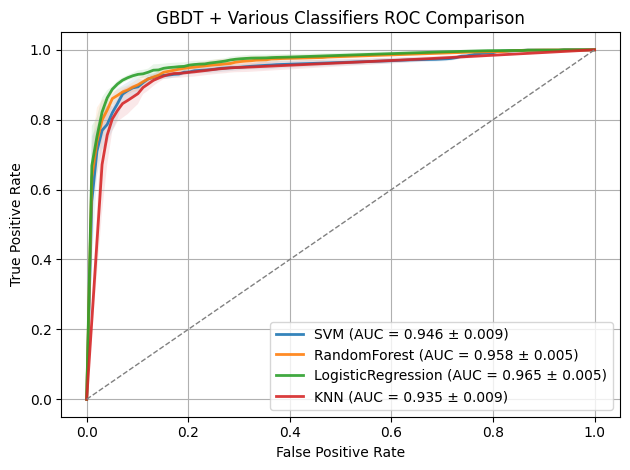

In [247]:
for name, (clf, param_grid) in classifiers.items():

    print(f" Running GBDT + {name} classifier...")

    pipeline = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', clf)
    ])

    grid = GridSearchCV(pipeline, param_grid, cv=3)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    roc_auc_scores = []
    scores = []
    i = 0

    for train_index, test_index in stratified_k_fold.split(selected_data_np, selected_label_np):
        X_train, X_test = selected_data_np[train_index], selected_data_np[test_index]
        y_train, y_test = selected_label_np[train_index], selected_label_np[test_index]

        X_train_trans = OHE.transform(GBDT.apply(X_train)[:, :, 0])
        X_test_trans = OHE.transform(GBDT.apply(X_test)[:, :, 0])

        grid.fit(X_train_trans, y_train)
        predicted_probs = grid.predict_proba(X_test_trans)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        roc_auc = auc(fpr, tpr)


        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)

        roc_auc_scores.append(roc_auc)
        scores.append(grid.score(X_test_trans, y_test))
        i += 1

        print(f"  Fold {i} : ROC AUC: {roc_auc:.4f} Accuracy: {grid.score(X_test_trans, y_test):.4f}")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(
        mean_fpr,
        mean_tpr,
        label=f'{name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})',
        lw=2,
        alpha=0.9
    )

    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, alpha=0.1)

    print(f"{name} Mean ROC AUC: {mean_auc:.4f}")
    print(f"{name} Mean Accuracy: {np.mean(scores):.4f}")


plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GBDT + Various Classifiers ROC Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
